In [1]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

def load_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [2]:
preprocessed_input = load_image('./images/stopsign.jpg')

In [3]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
from tensorflow.keras.applications.vgg16 import decode_predictions

predictions = model.predict(preprocessed_input)
top1 = decode_predictions(predictions)[0][0]

print('Predicted class:')
print('{}({}) with probability {:.2f}'.format(top1[1], top1[0], top1[2]))

Predicted class:
parking_meter(n03891332) with probability 0.68


In [6]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
import tensorflow.keras as keras
import tensorflow as tf
import cv2

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def grad_cam(input_model, image, category_index, layer_name):
    nb_classes = 1000
    
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)
    
    loss = K.sum(model.layers[-1].output)
    conv_output = [l for l in model.layers if l.name is layer_name][0].output
    
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])
    
    # input : 判定したい画像.shape => (1, 224, 224, 3)
    # output: 最後のconv層の出力値.shape => (1, 14, 14, 512),
    #         予想クラスの値から最後のconv層までの勾配.shape => (1, 14, 14, 512)
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0,:,:,:]
    # output.shape   => (14, 14, 512)
    # grad_val.shape => (14, 14, 512)
    
    weights = np.mean(grads_val, axis=(0,1))
    cam = np.ones(output.shape[0:2], dtype=np.float32)
    
    for i, w in enumerate(weights):
        cam += w * output[:,:,i]
    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0) # same as ReLU
    
    heatmap = cam / np.max(cam)
    
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)
    
    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

In [9]:
predicted_class = np.argmax(predictions)
cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block5_conv3")

gcam_out_path = "gradcam.jpg"
cv2.imwrite(gcam_out_path, cam)

True

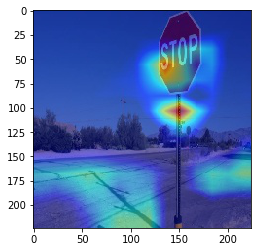

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

gcam_result = mpimg.imread(gcam_out_path)
plt.imshow(gcam_result)

## GuidedBackPropagation

In [ ]:
from tensorflow.python.framework import ops

def register_gradient():
    # GuidedBackPropが登録されていなかったら登録する
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        # ops.RegisterGradientというデコレーター関数に
        # _GuidedBackProp()関数を"GuidedBackProp"文字列と共に渡す
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * tf.cast(op.inputs[0] > 0., dtype)

In [ ]:
def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):
        layer_dict = [layer for layer in model.layers[1:] if hasattr(layer, 'activation')]
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu
                
        new_model = VGG16(weights='imagenet')
    return new_model

In [ ]:
def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

In [ ]:
def deprocess_image(x):
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]

ggcam_out_path = "guided_gradcam.jpg"
cv2.imwrite(ggcam_out_path, deprocess_image(gradcam))

In [ ]:
import matplotlib.pyplot as plt

ggcam_result = cv2.imread(ggcam_out_path)
plt.imshow(ggcam_result)

### Further Note
**Decorator**

In [ ]:
# base function
def test():
    print('Hello Decorator')
test()

In [ ]:
# decorated ex1: output value
def deco(func):
    def wrapper(*args, **kwargs):
        print('--start--')
        func(*args, **kwargs)
        print('--end--')
    return wrapper

@deco
def test():
    print('Hello Decorator')

test()

In [ ]:
# decorated ex2 : return value
def deco2(func):
    import os
    def wrapper(*args, **kwargs):
        res = '--start--' + os.linesep
        res += func(*args, **kwargs) + '!' + os.linesep
        res += '--end--'
        return res
    return wrapper

@deco2
def test2():
    return 'Hello Decorator'

print(test2())

In [ ]:
# decorated ex3: nested decorator
def deco_html(func):
    def wrapper(*args, **kwargs):
        res = '<html>'
        res = res + func(*args, **kwargs)
        res = res + '</html>'
        return res
    return wrapper

def deco_body(func):
    def wrapper(*args, **kwargs):
        res = '<body>'
        res = res + func(*args, **kwargs)
        res = res + '</body>'
        return res
    return wrapper

@deco_html
@deco_body
def test3():
    return 'Hello Decorator'

print(test3())

In [ ]:
# decorated ex4: function holding parameters
def deco_p(func):
    def wrapper(*args, **kwargs):
        res = '<p>'
        res += func(args[0], **kwargs)
        res += '</p>'
        return res
    return wrapper
    
@deco_p
def test4(input_str):
    return input_str

print(test4('Hello Decorator!'))

In [ ]:
# decorated ex5: pass parameters to decorator
def deco_tag(tag):
    def _deco_tag(func):
        def wrapper(*args, **kwargs):
            res = '<'+tag+'>'
            res += func(*args, **kwargs)
            res += '</'+tag+'>'
            return res
        return wrapper
    return _deco_tag

@deco_tag('html')
@deco_tag('body')
def test5():
    return 'Hello Decorator!'

print(test5())